<a href="https://colab.research.google.com/github/jhathaway5/OpenCV-Python-Series/blob/master/demo_sam2_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install required packages

In [1]:
!pip install torch torchvision
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-7tskzydl
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-7tskzydl
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=83d8cede2ad7ccf3e2fe6b9b98aa74fc9447ba7a2c36a93f30abcab8b7faff6c
  Stored in directory: /tmp/pip-ephem-wheel-cache-whoi64hk/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Import libraries

In [6]:
import torch
import torchvision
import cv2
import numpy as np
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt
import os


# Download the SAM2 model checkpoint

In [3]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-11-05 21:10:17--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.165.83.79, 18.165.83.91, 18.165.83.35, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.165.83.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   230MB/s    in 13s     

2024-11-05 21:10:30 (187 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



# Initialize the model

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)
predictor = SamPredictor(sam)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


# Give directory context

In [11]:
# Print current working directory
print(f"Current working directory: {os.getcwd()}")

# List all files in current directory
print("\nFiles in current directory:")
for file in os.listdir():
    print(f"- {file}")

Current working directory: /content

Files in current directory:
- .config
- rgb_20241104_101444.png
- rgb_20241104_101141.png
- sam_vit_h_4b8939.pth
- sample_data


# Load Image

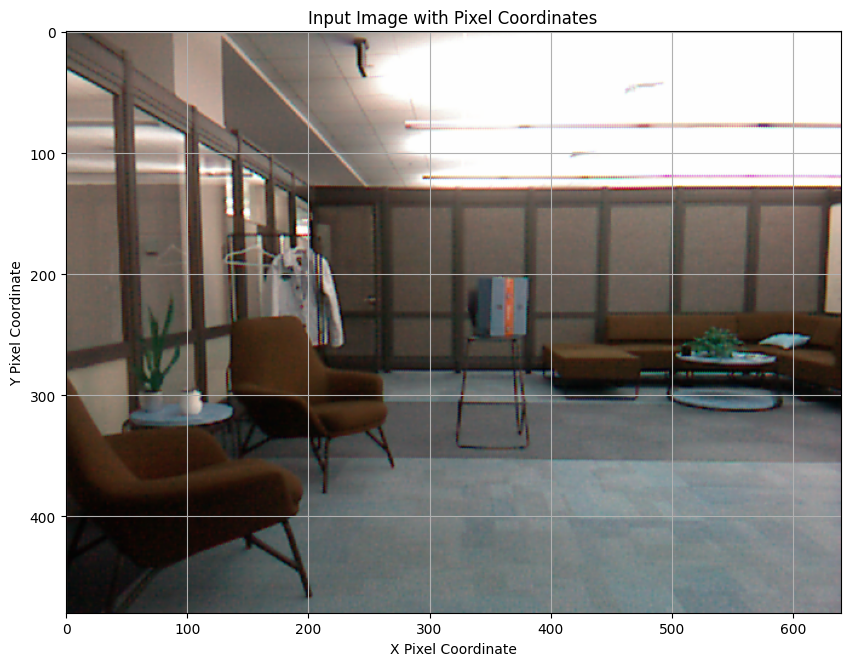

Image dimensions (height, width, channels): (480, 640, 3)


In [16]:
# Replace 'your_image.jpg' with your image path
image_path = 'rgb_20241104_101141.png'

# Read image with OpenCV and error checking
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"Failed to load image: {image_path}")

# Convert color space from BGR (OpenCV default) to RGB for proper display
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display image with pixel coordinates
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.grid(True)  # Show grid
plt.title('Input Image with Pixel Coordinates')
plt.xlabel('X Pixel Coordinate')
plt.ylabel('Y Pixel Coordinate')
plt.show()

# Print image dimensions for reference
print(f"Image dimensions (height, width, channels): {image.shape}")

# Compute the image embeddings

In [ ]:
# Set the input image for SAM model prediction
# This preprocesses the image and computes the image embeddings
# which are cached to speed up subsequent mask predictions
predictor.set_image(image)

# Preprocess an image

Here I am manually selecting two points for SAM2 to segment around.


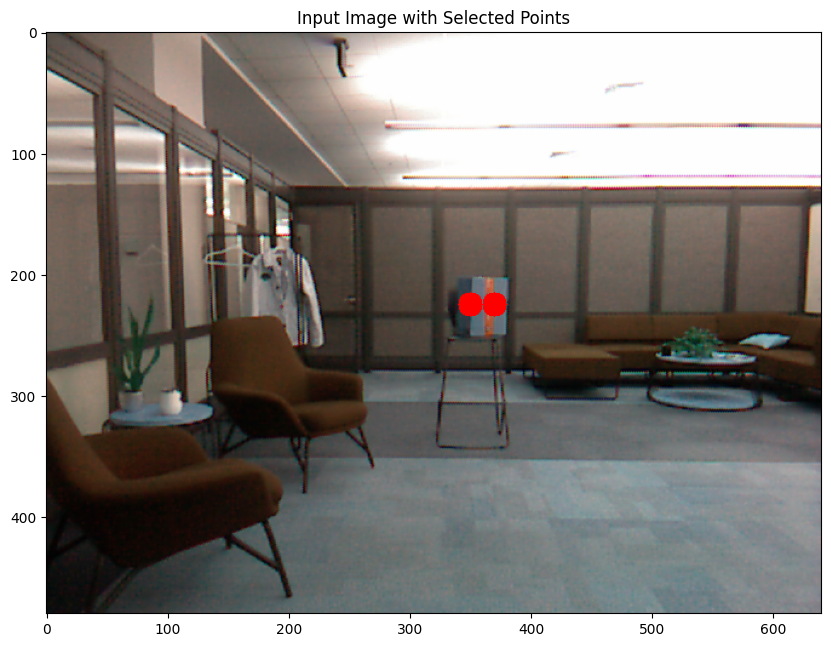

In [22]:

# Define input prompts (example with point prompts)
input_point = np.array([[350, 225], [370, 225]])  # Two example coordinates
input_label = np.array([1, 1])  # 1 indicates foreground for both points

# Create a copy of the image for visualization
image_with_point = image.copy()
# Draw red dots at the input points
point_radius = 10
point_color = (255, 0, 0)  # Red in RGB
cv2.circle(image_with_point, (input_point[0][0], input_point[0][1]), point_radius, point_color, -1)
cv2.circle(image_with_point, (input_point[1][0], input_point[1][1]), point_radius, point_color, -1)

# Display image with the points
plt.figure(figsize=(10, 10))
plt.imshow(image_with_point)
plt.title('Input Image with Selected Points')
plt.show()


# Perform Inference
Run SAM2 on the points and visualize the results

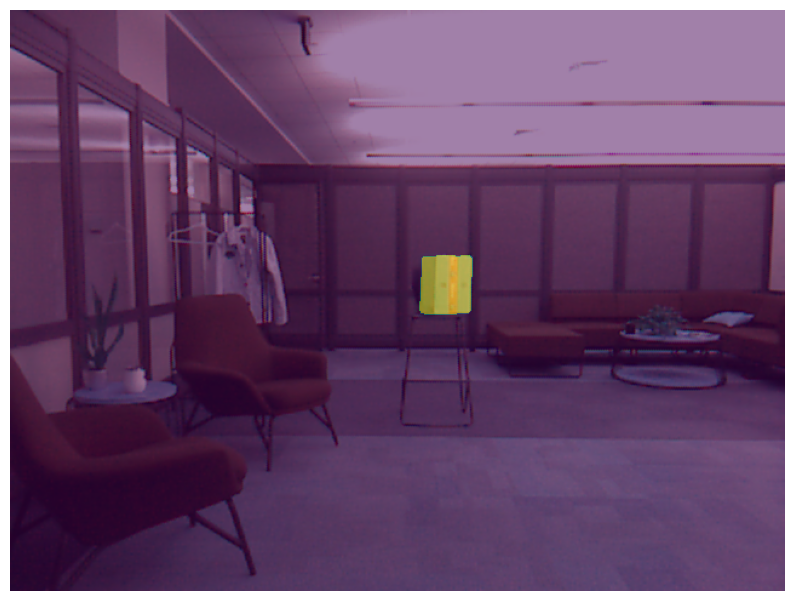

In [24]:
# Generate mask
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True
)

# Visualize the results
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')

# Show the mask with highest score
mask = masks[np.argmax(scores)]
plt.imshow(mask, alpha=0.5)  # Overlay mask on image
plt.show()
